# English Alphabet Classification with CNN

### 학번 : 2015113031
### 이름 : 이요한

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Import Packages

In [0]:
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
if torch.cuda.is_available():
    device = torch.device('cuda')          
else:
    device = torch.device('cpu')
    
print('device:', device)

device: cuda


### Hyperparameters

In [0]:
num_epochs = 30
batch_size = 10000
num_classes = 26
learning_rate = 0.01

### Define Custom Dataset

from Kaggle

https://www.kaggle.com/yairhadad1/cnn-for-handwritten-alphabets

https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader

https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

In [0]:
class CustomDatasetFromCSV(Dataset):
    def __init__(self, csv_path, height, width, transforms=None):
        """
        Args:
            csv_path (string): path to csv file
            height (int): image height
            width (int): image width
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data = pd.read_csv(csv_path)
        self.labels = np.asarray(self.data.iloc[:, 0])
        self.height = height
        self.width = width
        self.transforms = transforms

    def __getitem__(self, index):
        single_image_label = self.labels[index]
        # Read each 784 pixels and reshape the 1D array ([784]) to 2D array ([28,28]) 
        img_as_np = np.asarray(self.data.iloc[index][1:]).reshape(28,28).astype('uint8')
	    # Convert image from numpy array to PIL image, mode 'L' is for grayscale
        img_as_img = Image.fromarray(img_as_np)
        img_as_img = img_as_img.convert('L')
        # Transform image to tensor
        if self.transforms is not None:
            img_as_tensor = self.transforms(img_as_img)
        # Return image and the label
        return (img_as_tensor, single_image_label)

    def __len__(self):
        return len(self.data.index)
        

### Load Dataset

In [0]:
transformations = transforms.Compose([
                            transforms.ToTensor()
                        ])

alphabet_from_csv = CustomDatasetFromCSV("/content/drive/My Drive/A_Z Handwritten Data.csv",
                                                28, 28, transformations)

In [0]:
random_seed = 50
data_size = len(alphabet_from_csv)
indices = list(range(data_size))
split = int(np.floor(0.2 * data_size))
if True:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]
train_dataset = SubsetRandomSampler(train_indices)
test_dataset = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset = alphabet_from_csv,
                                           batch_size = batch_size,
                                           sampler = train_dataset)
test_loader = torch.utils.data.DataLoader(dataset = alphabet_from_csv,
                                          batch_size = batch_size,
                                          sampler = test_dataset)

### Preview data

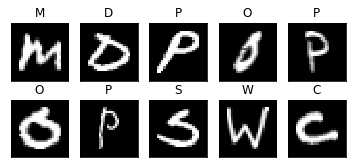

In [0]:
import matplotlib.pyplot as plt
import numpy as np

img_count = 2 * 5

fig = plt.figure()
ics = np.random.choice(len(alphabet_from_csv)-1, img_count)

img_index = []
lab_index = []
alphabet_mapping={0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G',
                  7:'H', 8:'I', 9:'J', 10:'K', 11:'L', 12:'M', 13:'N',
                  14:'O', 15:'P', 16:'Q', 17:'R', 18:'S', 19:'T', 20:'U',
                  21:'V', 22:'W', 23:'X', 24:'Y', 25:'Z'}

for ind in ics:

    imgs = alphabet_from_csv.__getitem__(ind)[0]
    labels = alphabet_from_csv.__getitem__(ind)[1]

    img_index.append(imgs)
    lab_index.append(labels)

for i in range(img_count):
    ax = fig.add_subplot(3, 5, i+1)
    ax.set_title(alphabet_mapping[lab_index[i]])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img_index[i].reshape(28,28), cmap='gray')

plt.show()



### Progress monitor

In [0]:
from IPython.display import HTML, display


# Custom IPython progress bar for training
class ProgressMonitor(object):
    
    tmpl = """
        <table style="width: 100%;">
            <tbody>
                <tr>
                    <td style="width: 30%;">
                     <b>Loss: {loss:0.4f}</b> &nbsp&nbsp&nbsp {value} / {length}
                    </td>
                    <td style="width: 70%;">
                        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
                    </td>
                </tr>
            </tbody>
        </table>        
        """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0), display_id=True)
        
    def html(self, count, loss):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss))
        
    def update(self, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss))

### Define CNN models

In [0]:
class ConvNet3(nn.Module):
    def __init__(self, num_classes=26):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 28, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(28),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p = 0.2)
        )
                # n x 28 x 14 x 14
        self.layer2 = nn.Sequential(
            nn.Conv2d(28, 56, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(56),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p = 0.25)
        )
                # n x 56 x 7 x 7
        self.layer3 = nn.Sequential(
            nn.Conv2d(56, 128, kernel_size=4, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p = 0.3)
        )
                # n x 128 x 4 x 4
        self.fc = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(128 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 26),
        )
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [0]:
model = ConvNet3(num_classes).to(device)

In [0]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train & Test

In [0]:
def train():
    # train phase
    model.train()
    
    # create a progress bar
    batch_loss_list = []
    progress = ProgressMonitor(length=len(train_dataset))

    for batch, target in train_loader:
        # Move the training data to the GPU
        batch, target = batch.to(device), target.to(device)

        # forward propagation
        output = model( batch )

        # calculate the loss
        loss = loss_func( output, target )
        
        # clear previous gradient computation
        optimizer.zero_grad()
 
        # backpropagate to compute gradients
        loss.backward()
 
        # update model weights
        optimizer.step()

        # update progress bar
        batch_loss_list.append(loss.item())
        progress.update(batch.shape[0], sum(batch_loss_list)/len(batch_loss_list) )

In [0]:
def test():
    # test phase
    model.eval()

    correct = 0
    
    # We don't need gradients for test, so wrap in 
    # no_grad to save memory
    with torch.no_grad():
        for batch, target in test_loader:
            # Move the training batch to the GPU
            batch, target = batch.to(device), target.to(device)

            # forward propagation
            output = model( batch )

            # get prediction
            output = torch.argmax(output, 1)

            # accumulate correct number
            correct += (output == target).sum().item()

    # Calculate test accuracy    
    acc = 100 * float(correct) / len(test_dataset) 
    print( 'Test accuracy: {}/{} ({:.2f}%)'.format( correct, len(test_dataset), acc ) )  

In [0]:
for epoch in range(num_epochs):
    
    print("{}'s try".format(int(epoch)+1))
    train()
    test()
    print("-----------------------------------------------------------------------------")

1's try


Loss: 0.8701 297960 / 297960,297960


Test accuracy: 64390/74490 (86.44%)
-----------------------------------------------------------------------------
2's try


Loss: 0.2099 297960 / 297960,297960


Test accuracy: 72432/74490 (97.24%)
-----------------------------------------------------------------------------
3's try


Loss: 0.1418 297960 / 297960,297960


Test accuracy: 72974/74490 (97.96%)
-----------------------------------------------------------------------------
4's try


Loss: 0.1138 297960 / 297960,297960


Test accuracy: 73188/74490 (98.25%)
-----------------------------------------------------------------------------
5's try


Loss: 0.1002 297960 / 297960,297960


Test accuracy: 73359/74490 (98.48%)
-----------------------------------------------------------------------------
6's try


Loss: 0.0895 297960 / 297960,297960


Test accuracy: 73540/74490 (98.72%)
-----------------------------------------------------------------------------
7's try


Loss: 0.0824 297960 / 297960,297960


Test accuracy: 73525/74490 (98.70%)
-----------------------------------------------------------------------------
8's try


Loss: 0.0776 297960 / 297960,297960


Test accuracy: 73630/74490 (98.85%)
-----------------------------------------------------------------------------
9's try


Loss: 0.0733 297960 / 297960,297960


Test accuracy: 73696/74490 (98.93%)
-----------------------------------------------------------------------------
10's try


Loss: 0.0705 297960 / 297960,297960


Test accuracy: 73710/74490 (98.95%)
-----------------------------------------------------------------------------
11's try


Loss: 0.0662 297960 / 297960,297960


Test accuracy: 73787/74490 (99.06%)
-----------------------------------------------------------------------------
12's try


Loss: 0.0639 297960 / 297960,297960


Test accuracy: 73756/74490 (99.01%)
-----------------------------------------------------------------------------
13's try


Loss: 0.0614 297960 / 297960,297960


Test accuracy: 73842/74490 (99.13%)
-----------------------------------------------------------------------------
14's try


Loss: 0.0599 297960 / 297960,297960


Test accuracy: 73765/74490 (99.03%)
-----------------------------------------------------------------------------
15's try


Loss: 0.0581 297960 / 297960,297960


Test accuracy: 73817/74490 (99.10%)
-----------------------------------------------------------------------------
16's try


Loss: 0.0573 297960 / 297960,297960


Test accuracy: 73780/74490 (99.05%)
-----------------------------------------------------------------------------
17's try


Loss: 0.0546 297960 / 297960,297960


Test accuracy: 73831/74490 (99.12%)
-----------------------------------------------------------------------------
18's try


Loss: 0.0537 297960 / 297960,297960


Test accuracy: 73872/74490 (99.17%)
-----------------------------------------------------------------------------
19's try


Loss: 0.0533 297960 / 297960,297960


Test accuracy: 73902/74490 (99.21%)
-----------------------------------------------------------------------------
20's try


Loss: 0.0528 297960 / 297960,297960


Test accuracy: 73878/74490 (99.18%)
-----------------------------------------------------------------------------
21's try


Loss: 0.0508 297960 / 297960,297960


Test accuracy: 73826/74490 (99.11%)
-----------------------------------------------------------------------------
22's try


Loss: 0.0505 297960 / 297960,297960


Test accuracy: 73899/74490 (99.21%)
-----------------------------------------------------------------------------
23's try


Loss: 0.0497 297960 / 297960,297960


Test accuracy: 73902/74490 (99.21%)
-----------------------------------------------------------------------------
24's try


Loss: 0.0479 297960 / 297960,297960


Test accuracy: 73957/74490 (99.28%)
-----------------------------------------------------------------------------
25's try


Loss: 0.0475 297960 / 297960,297960


Test accuracy: 73917/74490 (99.23%)
-----------------------------------------------------------------------------
26's try


Loss: 0.0473 297960 / 297960,297960


Test accuracy: 73916/74490 (99.23%)
-----------------------------------------------------------------------------
27's try


Loss: 0.0461 297960 / 297960,297960


Test accuracy: 73926/74490 (99.24%)
-----------------------------------------------------------------------------
28's try


Loss: 0.0455 297960 / 297960,297960


Test accuracy: 73955/74490 (99.28%)
-----------------------------------------------------------------------------
29's try


Loss: 0.0447 297960 / 297960,297960


Test accuracy: 73964/74490 (99.29%)
-----------------------------------------------------------------------------
30's try


Loss: 0.0448 297960 / 297960,297960


Test accuracy: 73944/74490 (99.27%)
-----------------------------------------------------------------------------


### Save & Load Model

In [0]:
path = '/content/drive/My Drive/model.pth'
torch.save(model.state_dict(), path)

In [0]:
new_model = ConvNet3(num_classes)
new_model.load_state_dict(torch.load(path))

<All keys matched successfully>

## Visuallization

https://pinkwink.kr/1129?category=580892

https://stackoverflow.com/questions/59097657/in-pytorch-how-to-test-simple-image-with-my-loaded-model

### Make Bounding Box

In [0]:
import cv2
import matplotlib.image as mpimg

In [0]:
im = cv2.imread('/content/drive/My Drive/my_handwritten.jpg')
img = im.copy()

# 그레이스케일로 변환하고 블러를 걸고 이진화하기
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)

# 윤곽 추출하기
# 두번째 매개변수를 cv2.RETR_LIST로 지정하면 모든 구간의 외곽을 검출합니다.
# 두번째 매개변수를 cv2.RETR_EXTERNAL로 지정하면 영역의 가장 외곽 부분만 검출합니다.
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
rects=[]
# 추출한 윤곽을 반복 처리하기
for cnt in contours:
  x, y, w, h = cv2.boundingRect(cnt)
  if h < 20: continue # 너무 작으면 건너뛰기
  red = (0, 255, 0)
  rects.append((x,y,w,h))

cv2.imwrite('my_handwritten_bounding.png', img) 

True

In [0]:
rects

[(172, 2052, 192, 232),
 (704, 1715, 193, 214),
 (1356, 1703, 152, 218),
 (438, 1703, 171, 259),
 (159, 1694, 130, 235),
 (1027, 1687, 154, 217),
 (1317, 1352, 195, 221),
 (992, 1339, 171, 246),
 (728, 1323, 195, 270),
 (166, 1315, 116, 265),
 (431, 1304, 170, 298),
 (1279, 964, 175, 236),
 (479, 957, 138, 227),
 (995, 955, 179, 222),
 (180, 939, 149, 222),
 (687, 917, 184, 251),
 (963, 567, 262, 217),
 (439, 559, 225, 249),
 (1287, 551, 148, 249),
 (730, 550, 135, 255),
 (152, 548, 166, 264),
 (1224, 219, 233, 233),
 (707, 219, 150, 206),
 (157, 207, 156, 227),
 (464, 206, 140, 222),
 (966, 190, 157, 250)]

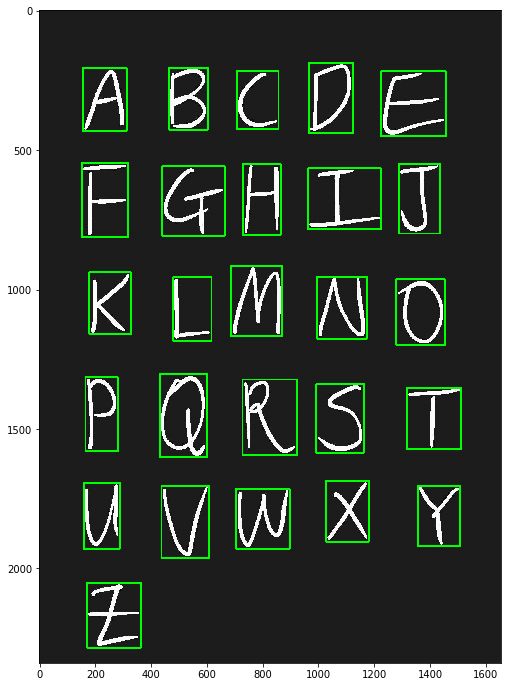

In [0]:
for rect in rects:
    cv2.rectangle(img, (rect[0], rect[1]), 
                  (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 5) 

plt.figure(figsize=(15, 12))
plt.imshow(img)

In [0]:
img_result = []
img_for_class = im.copy()

margin_pixel = 50

for rect in rects:
    #[y:y+h, x:x+w]
    img_result.append(
        img_for_class[rect[1]-margin_pixel : rect[1]+rect[3]+margin_pixel, 
                      rect[0]-margin_pixel : rect[0]+rect[2]+margin_pixel])
    
    # Draw the rectangles
    cv2.rectangle(im, (rect[0], rect[1]), 
                  (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 0) 

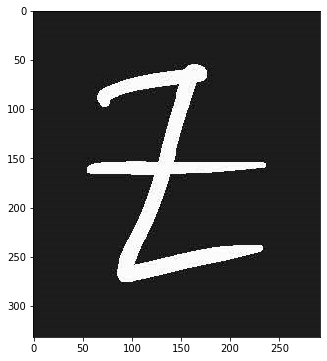

In [0]:
plt.figure(figsize=(8,6))
plt.imshow(img_result[0])

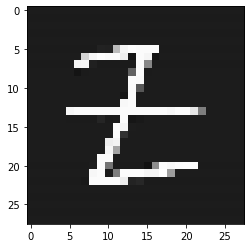

In [0]:
plt.figure(figsize=(4,4))
plt.imshow(cv2.resize(img_result[0], (28,28)));

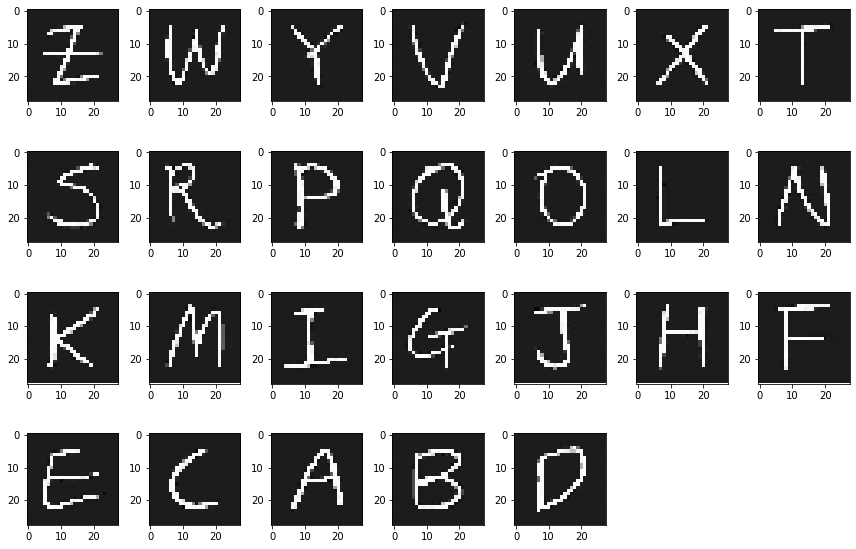

In [0]:
count = 0
nrows = 4
ncols = 7

plt.figure(figsize=(12,8))

for n in img_result:
    count += 1
    plt.subplot(nrows, ncols, count)
    plt.imshow(cv2.resize(n,(28,28)), cmap='Greys', interpolation='nearest')

plt.tight_layout()
plt.show()

### Test my handwritten letters

In [0]:
new_model.eval()

ConvNet3(
  (layer1): Sequential(
    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(28, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(56, 128, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)

In [0]:
# Convert 3d image -> 2d image
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [0]:
test_image = cv2.resize(img_result[1],(28,28))

gray = rgb2gray(test_image)
trans = transforms.Compose([transforms.ToTensor(),])

input_image = trans(gray).unsqueeze_(0)

output = new_model(input_image.float())
output = int(torch.argmax(output, 1))

In [0]:
output

22

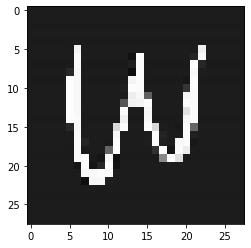

In [0]:
plt.imshow(test_image)

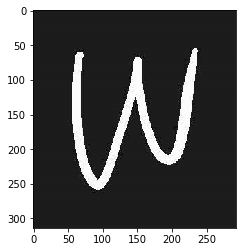

In [0]:
plt.imshow(img_result[1])

### Image Preprocessing

In [0]:
alphabet_mapping={0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G',
                  7:'H', 8:'I', 9:'J', 10:'K', 11:'L', 12:'M', 13:'N',
                  14:'O', 15:'P', 16:'Q', 17:'R', 18:'S', 19:'T', 20:'U',
                  21:'V', 22:'W', 23:'X', 24:'Y', 25:'Z'}

Answer: [W]


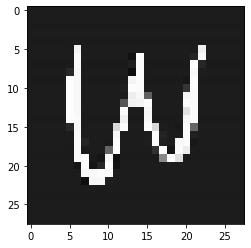

In [0]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

test_image = cv2.resize(img_result[1],(28,28))

gray = rgb2gray(test_image)
trans = transforms.Compose([transforms.ToTensor(),])

input_image = trans(gray).unsqueeze_(0)

output = new_model(input_image.float())
output = int(torch.argmax(output, 1))

print("Answer: [{}]".format(alphabet_mapping[output]))
plt.imshow(test_image)

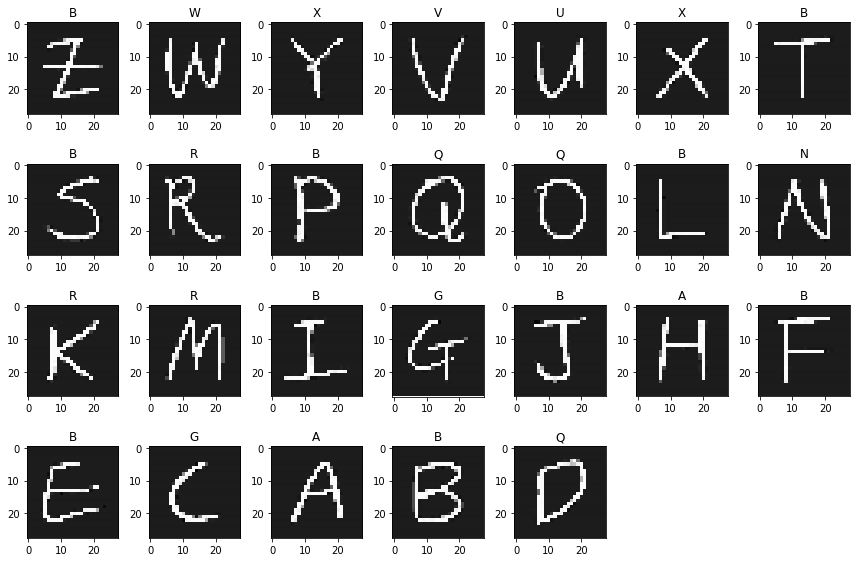

In [0]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

count = 0
nrows = 4
ncols = 7

plt.figure(figsize=(12,8))

for n in img_result:
    count += 1
    plt.subplot(nrows, ncols, count)

    test_image = cv2.resize(n,(28,28))
    gray = rgb2gray(test_image)
    trans = transforms.Compose([transforms.ToTensor(),])
    a = trans(gray).unsqueeze_(0)
    output = new_model(a.float())
    output = int(torch.argmax(output, 1))

    plt.imshow(cv2.resize(n,(28,28)), cmap='Greys', interpolation='nearest')
    plt.title(alphabet_mapping[output])
    
plt.tight_layout()
plt.show()

### Test

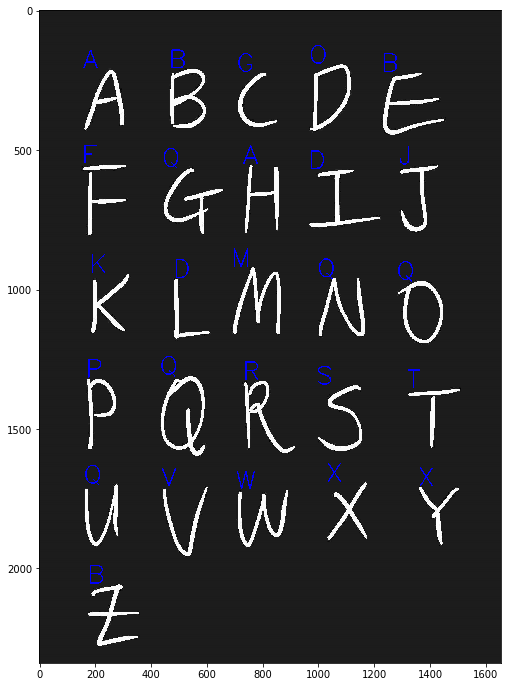

In [0]:
img_result = []
img_for_class = im.copy()

margin_pixel = 50

for rect in rects:

    target = img_for_class[rect[1]-margin_pixel : rect[1]+rect[3]+margin_pixel, 
                           rect[0]-margin_pixel : rect[0]+rect[2]+margin_pixel]
    
    test_image = cv2.resize(target,(28,28))
    gray = rgb2gray(test_image)
    trans = transforms.Compose([transforms.ToTensor(),])
    a = trans(gray).unsqueeze_(0)
    output = new_model(a.float())
    output = int(torch.argmax(output, 1))
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(im, alphabet_mapping[output], (rect[0], rect[1]), font, 3, (0, 0, 255), 3)

plt.figure(figsize=(15, 12))
plt.imshow(im)